
Самостоятельно напишите нейронную сеть, которая поможет распознавать болезни по симптомам. Используя подготовленную базу, создайте и обучите нейронную сеть, распознающую десять категорий
заболеваний: аппендицит, гастрит, гепатит, дуоденит, колит, панкреатит, холицестит, эзофагит, энтерит, язва. Добейтесь правильного распознавания 6 и более заболеваний

Сразу обратим внимание датасет небольшой и хороших результатов добится  сложно.

Ссылка на датасет:https://storage.yandexcloud.net/aiueducation/Content/base/l8/diseases.zip

### Импорты

In [3]:
# Работа с массивами данных
# Функции операционной системы
import os

# Работа со временем
import time

# Работа с архивами
import zipfile

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt
import numpy as np

# Матрица ошибок классификатора
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Основные слои
from tensorflow.keras.layers import (
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    MaxPooling1D,
    SpatialDropout1D,
)

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

%matplotlib inline

### Загрузка и распаковка архива

In [ ]:
# Скачаем архив с симптомами болезней
if not os.path.exists("diseases.zip"):
    gdown.download(
        "https://storage.yandexcloud.net/aiueducation/Content/base/l8/diseases.zip",
        None,
        quiet=True,
    )

'diseases.zip'

In [4]:
# Распакум архив
if not os.path.exists('dis'):
    with zipfile.ZipFile('diseases.zip', 'r') as zip_ref:
        zip_ref.extractall()

# Список файлов в папке
files = os.listdir('dis')
# Выведем список файлов
print("Список файлов в папке dis:")
for file in files:
    print(file)

Список файлов в папке dis:
Энтерит.txt
Аппендицит.txt
Холицестит.txt
Гастрит.txt
Язва.txt
Дуоденит.txt
Панкреатит.txt
Гепатит.txt
Колит.txt
Эзофагит.txt


### Подготовка данных

In [4]:
FILE_DIR  = 'dis/'                     # Папка с текстовыми файлами

In [5]:
# Подготовим пустые списки

CLASS_LIST = []  # Список классов
text_train = []  # Список для оучающей выборки
text_test = []   # Список для тестовой выборки

# Зададим коэффициент разделения текста на обучающую и текстовую выборки
split_coef = 0.8

# Получим списки файлов в папке
file_list = os.listdir(FILE_DIR)

for file_name in file_list:
    m = file_name.split('.') # Разделим имя файла и расширение
    class_name = m[0]        # Из имени файла получим название класса
    ext = m[1]               # Выделим расширение файла

    if ext=='txt':                                         # Если расширение txt то берем файл в работу
        if class_name not in CLASS_LIST:                   # Проверим, есть уже такой класс в списке
            print(f'Добавление класса "{class_name}"')     # Выведем имя нового класса
            CLASS_LIST.append(class_name)                  # Добавим новый класс в списоккласса "{class_name}"')

        cls = CLASS_LIST.index(class_name)                                        # Получим индекс (номер) нового класса
        print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}"')      # Сообщим о появлении нового класса

        with open(f'{FILE_DIR}/{file_name}', 'r') as f: # Откроем файл на чтение
            text = f.read()                                                       # Загрузка содержимого файла в строку
            text = text.replace('\n', ' ').split(' ')                             # Уберем символы перевода строк, получим список слов
            text_len=len(text)                                                    # Найдем количество прочитанных слов
            text_train.append(' '.join(text[:int(text_len*split_coef)]))          # Выделим часть файла в обучающую выборку
            text_test.append(' '.join(text[int(text_len*split_coef):]))           # Выделим часть файла в тестовую выборку



Добавление класса "Энтерит"
Добавление файла "Энтерит.txt" в класс "Энтерит"
Добавление класса "Аппендицит"
Добавление файла "Аппендицит.txt" в класс "Аппендицит"
Добавление класса "Холицестит"
Добавление файла "Холицестит.txt" в класс "Холицестит"
Добавление класса "Гастрит"
Добавление файла "Гастрит.txt" в класс "Гастрит"
Добавление класса "Язва"
Добавление файла "Язва.txt" в класс "Язва"
Добавление класса "Дуоденит"
Добавление файла "Дуоденит.txt" в класс "Дуоденит"
Добавление класса "Панкреатит"
Добавление файла "Панкреатит.txt" в класс "Панкреатит"
Добавление класса "Гепатит"
Добавление файла "Гепатит.txt" в класс "Гепатит"
Добавление класса "Колит"
Добавление файла "Колит.txt" в класс "Колит"
Добавление класса "Эзофагит"
Добавление файла "Эзофагит.txt" в класс "Эзофагит"


In [6]:
# Найдем получившееся количество классов
CLASS_COUNT = len(CLASS_LIST)

In [7]:
# Выведем число получившихся классов
print(CLASS_COUNT)

10


In [8]:
# Проверим загрузки: выведем начальные отрывки из каждого класса

for cls in range(CLASS_COUNT):             # Запустим цикл по числу классов
    print(f'Класс: {CLASS_LIST[cls]}')     # Выведем имя класса
    print(f'  train: {text_train[cls]}')   # Выведем фрагмент обучающей выборки
    print(f'  test : {text_test[cls]}')    # Выведем фрагмент тестовой выборки
    print()

Класс: Энтерит
  train: внезапныые боли (преимущественно в середине живота) рвота понос повышение температуры симптомы общей интоксикации сердечно-сосудистые расстройства обезвоживание организма возможны судороги  тошнота рвота понос повышение температуры тела боль в голове общая слабость бледность кожных покровов белый налет на языке вздутие живота метеоризм бурчание в животе отмечается боль в верхней части живота,вокруг пупка урчание и бурление в животе головокружение тахикардия  диарея тошнота рвота выраженное урчание в животе спастическая боль в верхней половине живота симптомы общей интоксикации организма: головная боль резкая слабость лихорадка (температура может достигать 39°С) бледность обложеность языка вздутие живота.   потеря аппетита тошнота рвота понос боли в области живота повышение температуры   водянистый понос, очень редко содержащий кровь колики боли в животе тошнота рвота  боли в животе понос тошнота рвота головные боли повышение температуры Стул – до 12-15 раз в сут

#### Контекстный менеджер

In [9]:
# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with

class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print('Время обработки: {:.2f} с'.format(time.time() - self.t))

#### Функции разделения последовательноси индексов на окна

In [22]:
#ваше решение
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [
        sequence[i : i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)
    ]


# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

#### Токенизация данных

In [ ]:
VOCAB_SIZE = 20000 # Максимальное количество слов в словаре
WIN_SIZE = 50 # Размер окна для скольжения
WIN_HOPE = 5 # Шаг окна для скольжения

In [ ]:
with timex():
    tokenizer = Tokenizer(  # Создание токенизатора
        num_words=VOCAB_SIZE,
        filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
        lower=True,
        split=" ",
        oov_token="неизвестное_слово",
        char_level=False,
    )
    tokenizer.fit_on_texts(text_train)  # Обучение токенизатора на обучающей выборке
    # Преобразование текстов в последовательности индексов
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)
    # Преобразование последовательностей в выборки отрезков и меток классов
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOPE)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOPE)

Время обработки: 0.02 с


### Функция проверки модели, отрисовка матрицы ошибок

In [45]:
def eval_model(
    model, history, x, y_true, class_labels=[], cm_round=3, title="", figsize=(10, 10)
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle("График процесса обучения модели")
    ax1.plot(
        history.history["accuracy"], label="Доля верных ответов на обучающем наборе"
    )
    ax1.plot(
        history.history["val_accuracy"],
        label="Доля верных ответов на проверочном наборе",
    )
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel("Эпоха обучения")
    ax1.set_ylabel("Доля верных ответов")
    ax1.legend()

    ax2.plot(history.history["loss"], label="Ошибка на обучающем наборе")
    ax2.plot(history.history["val_loss"], label="Ошибка на проверочном наборе")
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel("Эпоха обучения")
    ax2.set_ylabel("Ошибка")
    ax2.legend()
    plt.show()
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(
        np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), normalize="true"
    )
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f"Нейросеть {title}: матрица ошибок нормализованная", fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel("Предсказанные классы", fontsize=16)
    plt.ylabel("Верные классы", fontsize=16)
    fig.autofmt_xdate(rotation=45)  # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print("-" * 100)
    print(f"Нейросеть: {title}")

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = "ВЕРНО :-)" if cls_pred == cls else "НЕВЕРНО :-("
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print(
            "Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}".format(
                class_labels[cls],
                100.0 * cm[cls, cls_pred],
                class_labels[cls_pred],
                msg,
            )
        )

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print(
        "\nСредняя точность распознавания: {:3.0f}%".format(
            100.0 * cm.diagonal().mean()
        )
    )


### Создание и обучение модели

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 789ms/step - accuracy: 0.0928 - loss: 2.3086 - val_accuracy: 0.2017 - val_loss: 2.2867
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1965 - loss: 2.2784 - val_accuracy: 0.2146 - val_loss: 2.2595
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1870 - loss: 2.2434 - val_accuracy: 0.2146 - val_loss: 2.2198
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1891 - loss: 2.1954 - val_accuracy: 0.2146 - val_loss: 2.1703
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1976 - loss: 2.1303 - val_accuracy: 0.2146 - val_loss: 2.1299
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1857 - loss: 2.0663 - val_accuracy: 0.2146 - val_loss: 2.0976
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1944 - loss: 1.9806 - val_accuracy: 0.2146 - val_loss: 2.0551
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2731 - loss: 1.8198 - val_accuracy: 0.2532 - val_loss

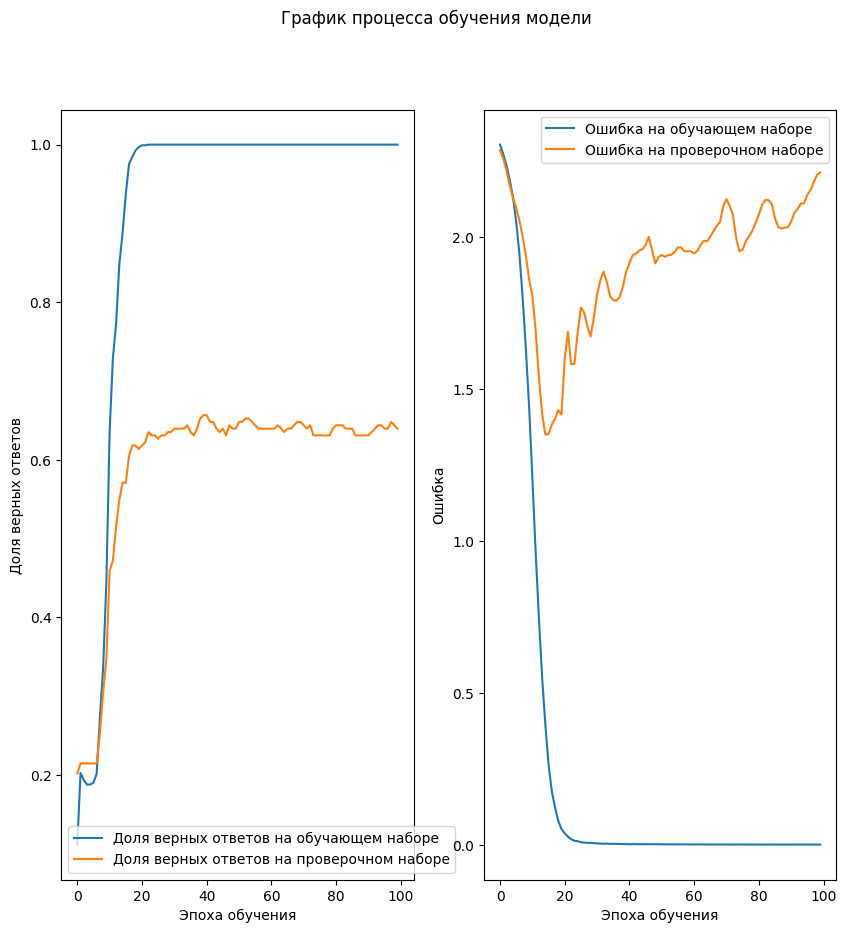

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


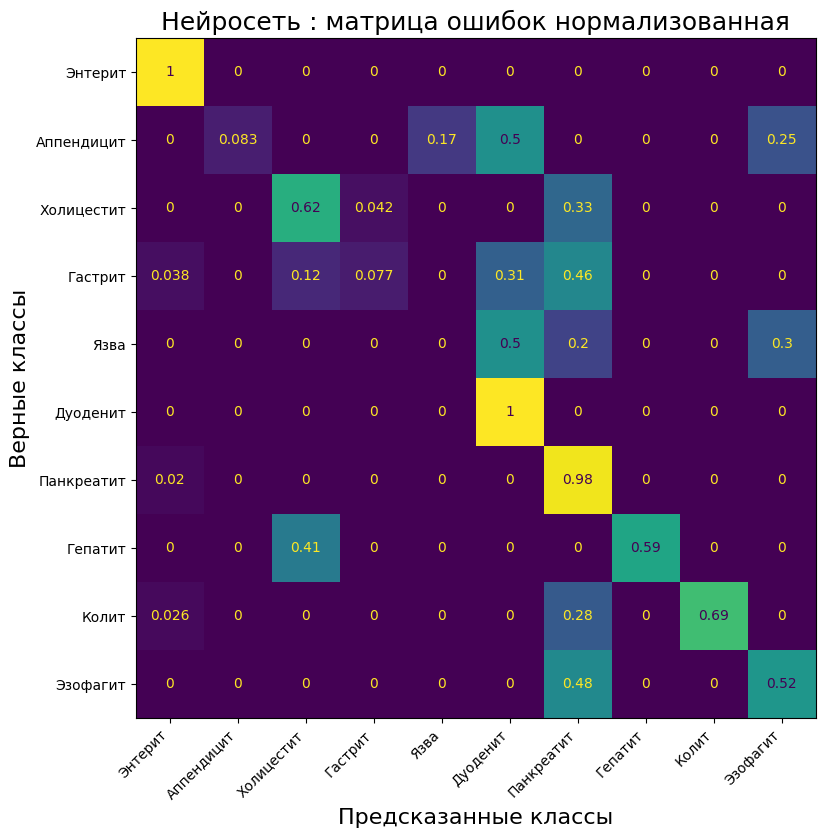

----------------------------------------------------------------------------------------------------
Нейросеть: 
Класс: Энтерит              100% сеть отнесла к классу Энтерит              - ВЕРНО :-)
Класс: Аппендицит            50% сеть отнесла к классу Дуоденит             - НЕВЕРНО :-(
Класс: Холицестит            62% сеть отнесла к классу Холицестит           - ВЕРНО :-)
Класс: Гастрит               46% сеть отнесла к классу Панкреатит           - НЕВЕРНО :-(
Класс: Язва                  50% сеть отнесла к классу Дуоденит             - НЕВЕРНО :-(
Класс: Дуоденит             100% сеть отнесла к классу Дуоденит             - ВЕРНО :-)
Класс: Панкреатит            98% сеть отнесла к классу Панкреатит           - ВЕРНО :-)
Класс: Гепатит               59% сеть отнесла к классу Гепатит              - ВЕРНО :-)
Класс: Колит                 69% сеть отнесла к классу Колит                - ВЕРНО :-)
Класс: Эзофагит              52% сеть отнесла к классу Эзофагит             - ВЕРНО :-)



In [ ]:
model = Sequential( # Создание модели нейронной сети
    [
        Embedding(VOCAB_SIZE, 100),
        SpatialDropout1D(0.2),
        # BatchNormalization(),
        Conv1D(20, 5, activation="relu", padding="same"),
        Conv1D(20, 5, activation="relu"),
        MaxPooling1D(2),
        Dropout(0.2),
        # BatchNormalization(),
        Flatten(),
        Dense(CLASS_COUNT, activation="softmax"),
    ]
)

# Компиляция модели с указанием оптимизатора, функции потерь и метрик
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

# Обучение модели на обучающей выборке с валидацией на тестовой выборке
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=256,
    validation_data=(x_test, y_test),
    verbose=1,
)

# Оценка модели на тестовой выборке и вывод результатов
eval_model(model, history, x_test, y_test, CLASS_LIST)
